In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#converting csv files to pandas dataframes
df_0 = pd.read_csv('data/CRMLSSold202412.csv')
df_1 = pd.read_csv('data/CRMLSSold202501_filled.csv')
df_2 = pd.read_csv('data/CRMLSSold202502.csv')
df_3 = pd.read_csv('data/CRMLSSold202503.csv')
df_4 = pd.read_csv('data/CRMLSSold202504.csv')
df_5 = pd.read_csv('data/CRMLSSold202505.csv')

In [3]:
#dropping 2 extra columns
df_1 = df_1.drop(columns=['latfilled','lonfilled'])

In [4]:
#list with all the dfs as elements in chronological order
all_dfs = [df_0,df_1,df_2,df_3,df_4,df_5]

In [5]:
#total number of rows in that month's df
total_rows=[]
for i in list(range(6)):
  total_rows.append(all_dfs[i].shape[0])

In [6]:
#creating one large df of all 6 months
mega = pd.concat(all_dfs, ignore_index=True)

In [7]:
#POA
#michael missingness table - impute values for less than 25% missing + missingness reason check if seems necessary
#poolprivate look at lot area- house area
#living area - check which categories/column we could use to impute results - possibly using normal distribution
#attached garden same as pool
#check univariate graphs for each feature
#try models like linear regression, (add more) - add evaluations for each model using train_test and cross validation

In [8]:
#drop agent related columns
cols_to_drop = [
    # agent / brokerage identifiers
    'ListAgentAOR', 'BuyerAgentAOR', 'BuyerAgentMlsId',
    'ListAgentFirstName', 'ListAgentLastName', 'ListAgentFullName',
    'BuyerAgentFirstName', 'BuyerAgentLastName',
    'CoListAgentFirstName', 'CoListAgentLastName', 'CoBuyerAgentFirstName',
    # office / brokerage names
    'ListOfficeName', 'BuyerOfficeName', 'CoListOfficeName', 'BuyerOfficeAOR',
    # contact info
    'ListAgentEmail',
    # MLS keys / IDs
    #could we making listingkey the index for uniqueness verification?
    'ListingKey', 'ListingKeyNumeric', 'ListingId',
    # listing-time prices
    'OriginalListPrice', 'ListPrice',
    # temporal status dates
    'CloseDate', 'ContractStatusChangeDate',
    'PurchaseContractDate', 'ListingContractDate', 'MlsStatus', 'DaysOnMarket'
    # other internal MLS fields
    'AssociationFeeFrequency', 'MLSAreaMajor', 'BusinessType'
]

mega_filtered = mega.drop(columns=cols_to_drop, errors='ignore').copy()

print(f"Remaining columns: {mega_filtered.columns}")

Remaining columns: Index(['Flooring', 'ViewYN', 'WaterfrontYN', 'BasementYN', 'PoolPrivateYN',
       'ClosePrice', 'Latitude', 'Longitude', 'UnparsedAddress',
       'PropertyType', 'LivingArea', 'DaysOnMarket', 'FireplacesTotal',
       'AssociationFeeFrequency', 'AboveGradeFinishedArea', 'TaxAnnualAmount',
       'CountyOrParish', 'ElementarySchool', 'AttachedGarageYN',
       'ParkingTotal', 'BuilderName', 'PropertySubType', 'LotSizeAcres',
       'SubdivisionName', 'YearBuilt', 'StreetNumberNumeric',
       'BathroomsTotalInteger', 'City', 'TaxYear', 'BuildingAreaTotal',
       'BedroomsTotal', 'ElementarySchoolDistrict', 'BelowGradeFinishedArea',
       'StateOrProvince', 'CoveredSpaces', 'MiddleOrJuniorSchool',
       'FireplaceYN', 'Stories', 'HighSchool', 'Levels', 'LotSizeDimensions',
       'LotSizeArea', 'MainLevelBedrooms', 'NewConstructionYN', 'GarageSpaces',
       'HighSchoolDistrict', 'PostalCode', 'AssociationFee',
       'LotSizeSquareFeet', 'MiddleOrJuniorSchoolDist

In [9]:
#dropping rows - only observations with PropertyType=“Residential” and PropertySubType=“SingleFamilyResidence”
mega_rc_filtered = mega_filtered.copy()
mega_rc_filtered = mega_rc_filtered[mega_rc_filtered['PropertyType']=='Residential']
mega_rc_filtered = mega_rc_filtered[mega_rc_filtered['PropertySubType']=='SingleFamilyResidence']
mega_rc_filtered

,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,...,LotSizeDimensions,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict
3,"Carpet,Laminate,Tile",False,NaN,NaN,NaN,1120000.0,37.330858,-121.849610,1182 Winslow Drive,Residential,...,NaN,6418.0,NaN,False,0.0,Other,95122,NaN,6418.0,NaN
12,NaN,True,NaN,NaN,False,890000.0,34.180411,-118.342020,1377 N Catalina Street,Residential,...,NaN,6473.0,3.0,False,1.0,Burbank Unified,91505,0.0,6473.0,NaN
13,NaN,False,NaN,NaN,False,1138000.0,32.574359,-117.023836,1252 Surfwood Ln,Residential,...,NaN,5219.0,NaN,False,3.0,NaN,92154,51.0,5219.0,NaN
14,Wood,True,NaN,True,False,670000.0,37.116859,-122.113773,12540 Irwin Way,Residential,...,NaN,61649.0,NaN,False,0.0,Other,95006,NaN,61649.0,NaN
15,NaN,True,NaN,NaN,False,681877.0,33.725080,-117.222302,25075 Butte Drive,Residential,...,NaN,7000.0,1.0,True,2.0,Mendocino Unified,92586,0.0,7000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125479,Carpet,False,NaN,NaN,False,510000.0,33.943555,-118.285762,624 W 102nd Street,Residential,...,NaN,4225.0,2.0,False,1.0,Los Angeles Unified,90044,0.0,4225.0,NaN
125505,Laminate,True,NaN,NaN,False,340000.0,33.731745,-116.728918,53455 Middle Ridge Drive,Residential,...,NaN,8712.0,NaN,False,0.0,NaN,92549,NaN,8712.0,NaN
125516,NaN,False,NaN,NaN,False,575000.0,34.264846,-118.426665,10716 Telfair Avenue,Residential,...,NaN,6750.0,3.0,False,2.0,Los Angeles Unified,91331,0.0,6750.0,NaN
125528,Carpet,True,NaN,NaN,True,3630000.0,33.834420,-116.548440,840 N PRESCOTT Drive,Residential,...,125x185,23087.0,NaN,False,3.0,NaN,92262,NaN,23087.0,NaN


In [10]:
# drop rows with null values in 'ClosePrice' 
mega_rc_filtered = mega_rc_filtered.dropna(subset=['ClosePrice'])


In [11]:
#michael missingness table
missing_pct = mega_rc_filtered.isnull().mean().sort_values(ascending=False)
missing_pct

TaxAnnualAmount                 1.000000
AboveGradeFinishedArea          1.000000
FireplacesTotal                 1.000000
MiddleOrJuniorSchoolDistrict    1.000000
TaxYear                         1.000000
ElementarySchoolDistrict        1.000000
CoveredSpaces                   1.000000
WaterfrontYN                    0.999402
BelowGradeFinishedArea          0.993682
BasementYN                      0.975972
BuilderName                     0.951749
LotSizeDimensions               0.937982
BuildingAreaTotal               0.934928
ElementarySchool                0.865428
MiddleOrJuniorSchool            0.865282
HighSchool                      0.823770
AssociationFeeFrequency         0.745754
SubdivisionName                 0.652242
MainLevelBedrooms               0.397512
Flooring                        0.360717
AssociationFee                  0.295742
HighSchoolDistrict              0.264620
Stories                         0.122534
AttachedGarageYN                0.117282
Levels          

In [12]:
#dropping columns that are more than 50% nulls
sparse = missing_pct[missing_pct > 0.5].index.tolist()
print(sparse)
#even though many seem logically relevant in pricing not enough data to include them in the model

mega_filtered_dropped = mega_rc_filtered.copy().drop(columns=sparse, errors='ignore')

missing_pct_fd = mega_filtered_dropped.copy().isnull().mean().sort_values(ascending=False) #new series of missingness percent
mega_fd = mega_filtered_dropped.copy()#copy of clean dataset to work with
mega_fd

['TaxAnnualAmount', 'AboveGradeFinishedArea', 'FireplacesTotal', 'MiddleOrJuniorSchoolDistrict', 'TaxYear', 'ElementarySchoolDistrict', 'CoveredSpaces', 'WaterfrontYN', 'BelowGradeFinishedArea', 'BasementYN', 'BuilderName', 'LotSizeDimensions', 'BuildingAreaTotal', 'ElementarySchool', 'MiddleOrJuniorSchool', 'HighSchool', 'AssociationFeeFrequency', 'SubdivisionName']


,Flooring,ViewYN,PoolPrivateYN,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,DaysOnMarket,...,Stories,Levels,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet
3,"Carpet,Laminate,Tile",False,NaN,1120000.0,37.330858,-121.849610,1182 Winslow Drive,Residential,1151.0,79,...,NaN,NaN,6418.0,NaN,False,0.0,Other,95122,NaN,6418.0
12,NaN,True,False,890000.0,34.180411,-118.342020,1377 N Catalina Street,Residential,1434.0,0,...,1.0,One,6473.0,3.0,False,1.0,Burbank Unified,91505,0.0,6473.0
13,NaN,False,False,1138000.0,32.574359,-117.023836,1252 Surfwood Ln,Residential,2872.0,0,...,2.0,Two,5219.0,NaN,False,3.0,NaN,92154,51.0,5219.0
14,Wood,True,False,670000.0,37.116859,-122.113773,12540 Irwin Way,Residential,800.0,0,...,NaN,NaN,61649.0,NaN,False,0.0,Other,95006,NaN,61649.0
15,NaN,True,False,681877.0,33.725080,-117.222302,25075 Butte Drive,Residential,2824.0,0,...,2.0,Two,7000.0,1.0,True,2.0,Mendocino Unified,92586,0.0,7000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125479,Carpet,False,False,510000.0,33.943555,-118.285762,624 W 102nd Street,Residential,1014.0,288,...,1.0,One,4225.0,2.0,False,1.0,Los Angeles Unified,90044,0.0,4225.0
125505,Laminate,True,False,340000.0,33.731745,-116.728918,53455 Middle Ridge Drive,Residential,648.0,563,...,NaN,NaN,8712.0,NaN,False,0.0,NaN,92549,NaN,8712.0
125516,NaN,False,False,575000.0,34.264846,-118.426665,10716 Telfair Avenue,Residential,944.0,45,...,1.0,One,6750.0,3.0,False,2.0,Los Angeles Unified,91331,0.0,6750.0
125528,Carpet,True,True,3630000.0,33.834420,-116.548440,840 N PRESCOTT Drive,Residential,4867.0,648,...,NaN,NaN,23087.0,NaN,False,3.0,NaN,92262,NaN,23087.0


In [13]:
# categorized based on missing ratio
drop_missing_cols = missing_pct[missing_pct > 0.99].index.tolist()

print(f">99% missing columns ({len(drop_missing_cols)})")
print(drop_missing_cols)
mega_fd = mega_fd.drop(columns=drop_missing_cols, errors='ignore')

def bucket_missing_rate_v2(rate):
    if rate >= 0.8:
        return 'High Missing (>80%)'
    elif rate >= 0.5:
        return 'Upper-Medium Missing (50%-80%)'
    elif rate >= 0.2:
        return 'Lower-Medium Missing (20%-50%)'
    else:
        return 'Low Missing (<20%)'

missing_df = missing_pct.drop(index = drop_missing_cols).reset_index()
missing_df.columns = ['Column', 'MissingRate']
missing_df['Bucket'] = missing_df['MissingRate'].apply(bucket_missing_rate_v2)

bucket_counts = missing_df['Bucket'].value_counts()

print("\nMissing Value Bucket Summary (4 Buckets):")
print(bucket_counts)

for bucket in ['High Missing (>80%)', 'Upper-Medium Missing (50%-80%)',
               'Lower-Medium Missing (20%-50%)', 'Low Missing (<20%)']:
    print(f"\n{bucket} columns:")
    display(missing_df[missing_df['Bucket'] == bucket][['Column', 'MissingRate']])

>99% missing columns (9)
['TaxAnnualAmount', 'AboveGradeFinishedArea', 'FireplacesTotal', 'MiddleOrJuniorSchoolDistrict', 'TaxYear', 'ElementarySchoolDistrict', 'CoveredSpaces', 'WaterfrontYN', 'BelowGradeFinishedArea']

Missing Value Bucket Summary (4 Buckets):
Bucket
Low Missing (<20%)                28
High Missing (>80%)                7
Lower-Medium Missing (20%-50%)     4
Upper-Medium Missing (50%-80%)     2
Name: count, dtype: int64

High Missing (>80%) columns:


,Column,MissingRate
0,BasementYN,0.975972
1,BuilderName,0.951749
2,LotSizeDimensions,0.937982
3,BuildingAreaTotal,0.934928
4,ElementarySchool,0.865428
5,MiddleOrJuniorSchool,0.865282
6,HighSchool,0.823770



Upper-Medium Missing (50%-80%) columns:


,Column,MissingRate
7,AssociationFeeFrequency,0.745754
8,SubdivisionName,0.652242



Lower-Medium Missing (20%-50%) columns:


,Column,MissingRate
9,MainLevelBedrooms,0.397512
10,Flooring,0.360717
11,AssociationFee,0.295742
12,HighSchoolDistrict,0.264620



Low Missing (<20%) columns:


,Column,MissingRate
13,Stories,0.122534
14,AttachedGarageYN,0.117282
15,Levels,0.087808
16,PoolPrivateYN,0.087566
17,ViewYN,0.086984
18,NewConstructionYN,0.072780
19,GarageSpaces,0.037828
20,LotSizeAcres,0.018211
21,LotSizeSquareFeet,0.018147
22,LotSizeArea,0.018114


In [14]:
#investigating duplicates
print(mega_fd.shape[0])
mega_fd['UnparsedAddress'].value_counts()>1

61885


UnparsedAddress
24784 Metric Drive           True
3937 2nd Avenue              True
29835 Camino Cristal         True
11242 Lakeland Road          True
1717 W 69th Street           True
                            ...  
624 W 102nd Street          False
53455 Middle Ridge Drive    False
10716 Telfair Avenue        False
840 N PRESCOTT Drive        False
23979 Citrus Avenue         False
Name: count, Length: 61475, dtype: bool

In [15]:
#checking for missingness dependencies for better imputation
df = mega_fd.copy()

pval_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

#classify columns by datatype
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

# loop through each column to check for missingness dependency
for target_col in df.columns:
    # Create binary mask: 1 if missing, 0 if not
    is_missing = df[target_col].isna().astype(int)

    for predictor_col in df.columns:
        if target_col == predictor_col:
            pval_matrix.loc[target_col, predictor_col] = np.nan
            continue

        predictor = df[predictor_col]

        # Only look at rows where predictor is not missing
        mask = ~predictor.isna()
        try:
            if predictor_col in categorical_cols:
                # Create contingency table
                contingency = pd.crosstab(is_missing[mask], predictor[mask])

                # If 2x2 table, use Fisher's Exact test (better for small samples)
                if contingency.shape == (2, 2):
                    _, p = fisher_exact(contingency)
                else:
                    # Larger tables → chi-squared test
                    _, p, _, _ = chi2_contingency(contingency)

            elif predictor_col in numerical_cols:
                # Split numerical predictor by missingness of target
                group1 = predictor[(is_missing == 1) & mask]
                group0 = predictor[(is_missing == 0) & mask]

                if len(group1) > 0 and len(group0) > 0:
                    # Use Mann-Whitney U test (non-parametric)
                    _, p = mannwhitneyu(group1, group0, alternative='two-sided')
                else:
                    p = np.nan
            else:
                p = np.nan

        except Exception:
            p = np.nan

        pval_matrix.loc[target_col, predictor_col] = p


pval_matrix

,Flooring,ViewYN,PoolPrivateYN,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,DaysOnMarket,...,Stories,Levels,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet
Flooring,NaN,4.723620e-208,1.086589e-18,8.240234e-207,0.000000e+00,0.000000e+00,0.394342,1.0,6.939076e-110,8.690836e-13,...,1.707050e-29,1.185900e-40,1.870455e-01,1.275963e-02,2.535839e-01,1.913900e-21,0.000000e+00,0.000000e+00,1.275076e-166,2.518426e-03
ViewYN,1.092208e-247,NaN,0.000000e+00,1.744115e-10,0.000000e+00,0.000000e+00,0.188879,1.0,7.840240e-28,3.757132e-45,...,3.541014e-04,1.464713e-11,4.418003e-82,5.979406e-01,3.161093e-23,2.126648e-81,0.000000e+00,0.000000e+00,4.903853e-261,4.390253e-137
PoolPrivateYN,0.000000e+00,1.249329e-238,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.213599,1.0,1.702390e-15,1.241616e-51,...,1.226731e-14,2.447775e-117,1.090766e-04,7.642783e-02,1.559545e-56,1.159863e-48,0.000000e+00,0.000000e+00,1.553031e-217,1.277090e-01
ClosePrice,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,...,NaN,1.000000e+00,NaN,NaN,1.000000e+00,NaN,1.000000e+00,1.000000e+00,NaN,NaN
Latitude,1.000000e+00,1.000000e+00,1.000000e+00,9.730839e-01,NaN,NaN,0.161169,1.0,5.656589e-01,6.175761e-01,...,2.513485e-01,9.999540e-01,2.237058e-01,NaN,9.051939e-03,4.226679e-01,1.921245e-35,1.642359e-57,NaN,1.693573e-01
Longitude,1.000000e+00,1.000000e+00,1.000000e+00,9.730839e-01,NaN,NaN,0.161169,1.0,5.656589e-01,6.175761e-01,...,2.513485e-01,9.999540e-01,2.237058e-01,NaN,9.051939e-03,4.226679e-01,1.921245e-35,1.642359e-57,NaN,1.693573e-01
UnparsedAddress,1.000000e+00,1.000000e+00,1.326513e-02,4.906866e-01,1.467296e-02,1.325195e-01,NaN,1.0,4.448763e-01,2.003416e-03,...,5.181331e-01,1.857782e-01,9.399347e-01,4.071830e-02,1.449641e-09,5.269980e-02,4.337357e-16,5.670938e-28,9.734267e-01,8.446675e-01
PropertyType,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,1.000000e+00,NaN,NaN,1.000000e+00,NaN,1.000000e+00,1.000000e+00,NaN,NaN
LivingArea,1.000000e+00,4.002662e-02,7.692691e-01,4.201955e-13,6.800084e-01,1.909193e-03,0.161169,1.0,NaN,2.167847e-01,...,9.476010e-01,6.657751e-13,2.017016e-02,1.139218e-01,1.626437e-01,4.256394e-01,1.212514e-42,6.858361e-88,8.455248e-01,5.307940e-02
DaysOnMarket,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,...,NaN,1.000000e+00,NaN,NaN,1.000000e+00,NaN,1.000000e+00,1.000000e+00,NaN,NaN


In [16]:
numerical_cols = mega_fd.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = mega_fd.select_dtypes(include=['object']).columns.tolist()
numerical_cols

['ClosePrice',
 'Latitude',
 'Longitude',
 'LivingArea',
 'DaysOnMarket',
 'ParkingTotal',
 'LotSizeAcres',
 'YearBuilt',
 'StreetNumberNumeric',
 'BathroomsTotalInteger',
 'BedroomsTotal',
 'Stories',
 'LotSizeArea',
 'MainLevelBedrooms',
 'GarageSpaces',
 'AssociationFee',
 'LotSizeSquareFeet']

In [17]:
#finding significant values
significant = pval_matrix < 0.05
significant

,Flooring,ViewYN,PoolPrivateYN,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,DaysOnMarket,...,Stories,Levels,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet
Flooring,False,True,True,True,True,True,False,False,True,True,...,True,True,False,True,False,True,True,True,True,True
ViewYN,True,False,True,True,True,True,False,False,True,True,...,True,True,True,False,True,True,True,True,True,True
PoolPrivateYN,True,True,False,True,True,True,False,False,True,True,...,True,True,True,False,True,True,True,True,True,False
ClosePrice,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Latitude,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,True,False,False
Longitude,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,True,False,False
UnparsedAddress,False,False,True,False,True,False,False,False,False,True,...,False,False,False,True,True,False,True,True,False,False
PropertyType,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LivingArea,False,True,False,True,False,True,False,False,False,False,...,False,True,True,False,False,False,True,True,False,False
DaysOnMarket,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
#missingness in mega_fd
missing_pct_fd


MainLevelBedrooms        0.397512
Flooring                 0.360717
AssociationFee           0.295742
HighSchoolDistrict       0.264620
Stories                  0.122534
AttachedGarageYN         0.117282
Levels                   0.087808
PoolPrivateYN            0.087566
ViewYN                   0.086984
NewConstructionYN        0.072780
GarageSpaces             0.037828
LotSizeAcres             0.018211
LotSizeSquareFeet        0.018147
LotSizeArea              0.018114
StreetNumberNumeric      0.001228
UnparsedAddress          0.001034
City                     0.000921
YearBuilt                0.000921
FireplaceYN              0.000614
LivingArea               0.000582
BathroomsTotalInteger    0.000145
Latitude                 0.000065
Longitude                0.000065
PropertyType             0.000000
ParkingTotal             0.000000
PropertySubType          0.000000
DaysOnMarket             0.000000
CountyOrParish           0.000000
ClosePrice               0.000000
BedroomsTotal 

In [19]:
significant.sum(axis=1).sort_values()

ClosePrice                0
PropertyType              0
CountyOrParish            0
DaysOnMarket              0
ParkingTotal              0
PropertySubType           0
StateOrProvince           0
BedroomsTotal             0
PostalCode                0
BathroomsTotalInteger     1
Latitude                  6
Longitude                 6
UnparsedAddress          10
LivingArea               12
StreetNumberNumeric      13
City                     13
FireplaceYN              14
YearBuilt                16
LotSizeArea              20
LotSizeSquareFeet        22
LotSizeAcres             22
Levels                   22
GarageSpaces             22
NewConstructionYN        23
HighSchoolDistrict       24
PoolPrivateYN            24
Flooring                 25
ViewYN                   25
AssociationFee           25
AttachedGarageYN         27
Stories                  27
MainLevelBedrooms        27
dtype: int64

In [20]:
# check null values in numerical columns
numerical_nulls = mega_fd[numerical_cols].isnull().sum()
with_null = numerical_nulls[numerical_nulls > 0]


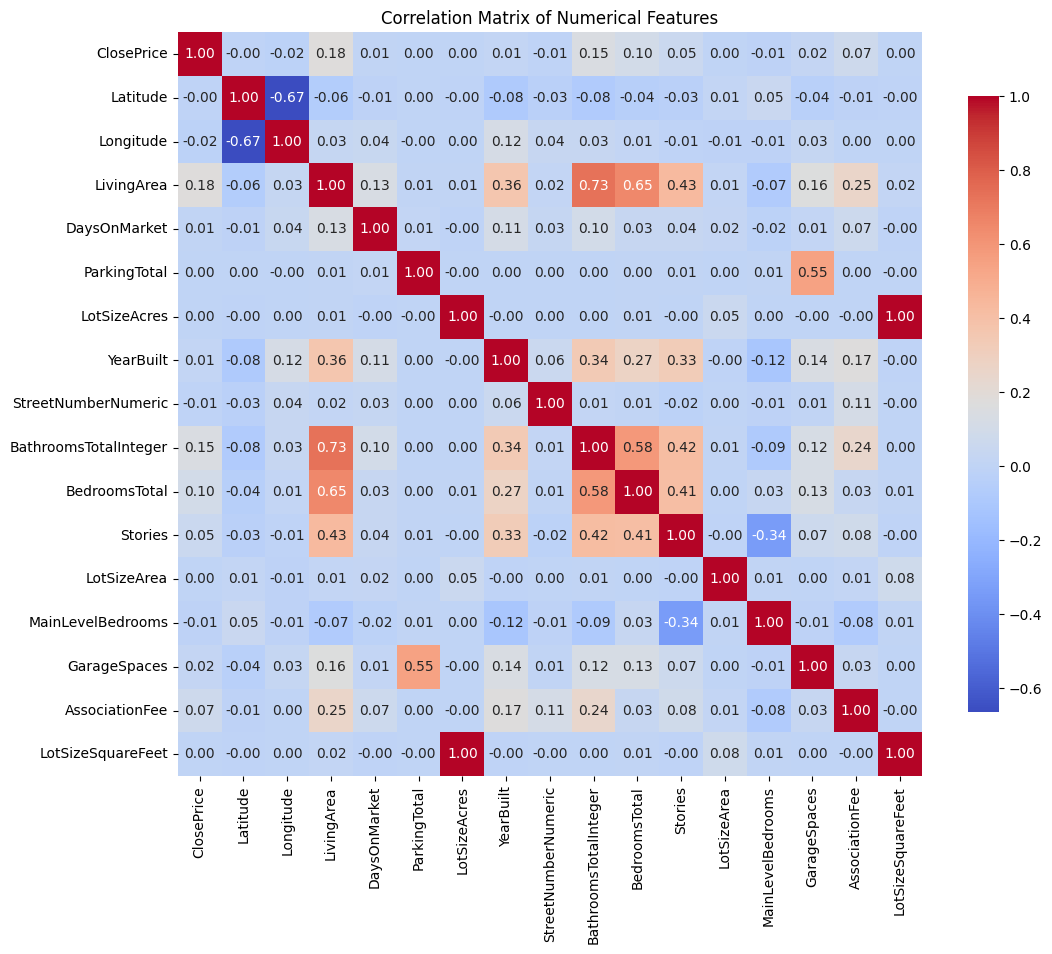

In [21]:
# correlation matrix graph
plt.figure(figsize=(12, 10))
correlation_matrix = mega_fd[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [22]:
mega_fd['GarageSpaces'] = mega_fd['GarageSpaces'].fillna(0)
mega_fd['MainLevelBedrooms'] = mega_fd['MainLevelBedrooms'].fillna(0)


In [23]:
mega_fd.drop(columns=['LotSizeAcres','StreetNumberNumeric'], inplace=True)


# Final Filtered Dataset and Predictive Modeling

This section displays the final cleaned dataset and builds a simple model to predict the close price of a property based on its characteristics.

In [24]:
# Display the final filtered dataset ready for modeling
print('Final dataset shape:', mega_fd.shape)
display(mega_fd.head())
print('Columns:', mega_fd.columns.tolist())

Final dataset shape: (61885, 30)


,Flooring,ViewYN,PoolPrivateYN,ClosePrice,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,DaysOnMarket,...,Stories,Levels,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet
3,"Carpet,Laminate,Tile",False,NaN,1120000.0,37.330858,-121.849610,1182 Winslow Drive,Residential,1151.0,79,...,NaN,NaN,6418.0,0.0,False,0.0,Other,95122,NaN,6418.0
12,NaN,True,False,890000.0,34.180411,-118.342020,1377 N Catalina Street,Residential,1434.0,0,...,1.0,One,6473.0,3.0,False,1.0,Burbank Unified,91505,0.0,6473.0
13,NaN,False,False,1138000.0,32.574359,-117.023836,1252 Surfwood Ln,Residential,2872.0,0,...,2.0,Two,5219.0,0.0,False,3.0,NaN,92154,51.0,5219.0
14,Wood,True,False,670000.0,37.116859,-122.113773,12540 Irwin Way,Residential,800.0,0,...,NaN,NaN,61649.0,0.0,False,0.0,Other,95006,NaN,61649.0
15,NaN,True,False,681877.0,33.725080,-117.222302,25075 Butte Drive,Residential,2824.0,0,...,2.0,Two,7000.0,1.0,True,2.0,Mendocino Unified,92586,0.0,7000.0


Columns: ['Flooring', 'ViewYN', 'PoolPrivateYN', 'ClosePrice', 'Latitude', 'Longitude', 'UnparsedAddress', 'PropertyType', 'LivingArea', 'DaysOnMarket', 'CountyOrParish', 'AttachedGarageYN', 'ParkingTotal', 'PropertySubType', 'YearBuilt', 'BathroomsTotalInteger', 'City', 'BedroomsTotal', 'StateOrProvince', 'FireplaceYN', 'Stories', 'Levels', 'LotSizeArea', 'MainLevelBedrooms', 'NewConstructionYN', 'GarageSpaces', 'HighSchoolDistrict', 'PostalCode', 'AssociationFee', 'LotSizeSquareFeet']


In [25]:
# columns without null values
mega_fd.columns[mega_fd.isnull().any()==False].tolist()

['ClosePrice',
 'PropertyType',
 'DaysOnMarket',
 'CountyOrParish',
 'ParkingTotal',
 'PropertySubType',
 'BedroomsTotal',
 'StateOrProvince',
 'MainLevelBedrooms',
 'GarageSpaces',
 'PostalCode']

## Predicting House Price

We will use a simple linear regression model to predict the close price of a property based on its available characteristics.

In [26]:
# remove columns with null values
# cols_with_nulls = mega_fd.columns[mega_fd.isnull().any()].tolist()
# mega_fd = mega_fd.drop(columns=cols_with_nulls)

# remove rows with null values 
mega_fd = mega_fd.dropna()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# numerical columns for KNN
num_cols = mega_fd.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col != 'ClosePrice']
df_knn = mega_fd[num_cols + ['ClosePrice']].dropna()

X = df_knn[num_cols]
y = df_knn['ClosePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"KNN MAPE: {MAPE:.2f}")
print(f"KNN R-squared: {r2:.3f}")

KNN MAE: 0.43
KNN R-squared: 0.317


In [ ]:
# with categorical variables
df_no_null_cols = mega_fd.dropna(axis=1)

feature_cols = [col for col in df_no_null_cols.columns if col != 'ClosePrice']

df_no_null_cols = df_no_null_cols.dropna(subset=['ClosePrice'])

X = df_no_null_cols[feature_cols]
y = df_no_null_cols['ClosePrice']

# one-hot encoding categorical variables
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"KNN MAPE (all columns, no nulls): {MAPE:.2f}")
print(f"KNN R-squared (all columns, no nulls): {r2:.3f}")

KNN MAE (all columns, no nulls): 0.43
KNN R-squared (all columns, no nulls): 0.317


# neural network

In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select only numerical columns except the target
num_cols = mega_fd.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col != 'ClosePrice']

# Drop rows with nulls in numerical columns or target
df_nn = mega_fd[num_cols + ['ClosePrice']].dropna()

X = df_nn[num_cols].values
y = df_nn['ClosePrice'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the neural network regressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MLPRegressor MAPE: {MAPE:.2f}")
print(f"MLPRegressor R-squared: {r2:.3f}")

MLPRegressor MAE: 0.39
MLPRegressor R-squared: 0.483


c:\Users\kangy\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
# remove the top and bottom 1% of ClosePrice
lower_bound = mega_fd['ClosePrice'].quantile(0.01)
upper_bound = mega_fd['ClosePrice'].quantile(0.99)
mega_fd_filtered = mega_fd[(mega_fd['ClosePrice'] >= lower_bound) & (mega_fd['ClosePrice'] <= upper_bound)]

# Re-run the neural network model with filtered data
num_cols = mega_fd_filtered.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col != 'ClosePrice']

# Drop rows with nulls in numerical columns or target
df_nn = mega_fd_filtered[num_cols + ['ClosePrice']].dropna()

X = df_nn[num_cols].values
y = df_nn['ClosePrice'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the neural network regressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MLPRegressor MAPE: {MAPE:.2f}")
print(f"MLPRegressor R-squared: {r2:.3f}")

MLPRegressor MAPE: 0.32
MLPRegressor R-squared: 0.527


c:\Users\kangy\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
